# Proyecto Galaxias
___
## Configuramos nuestro entorno Spark

Antes de empezar debemos importar los paquetes y módulos que vamos a necesitar durante este análisis. En concreto, vamos a importar el paquete de visualización *matplotlib*, el módulo *Pandas* para trabajar con datos tabulares y algunas funciones de *Spark*.

`Importante: La forma ideal de hacerlo es con hive teniendo hadoop instalado (por ejemplo, usando la maquina virtual gratuita de cloudera), pero para hacerlo de una manera mas amena y sin necesidad de configurar nada utilizare directamente spark en memoria para cargar los datos`

In [2]:
import pandas as pd
from pyspark.sql import SparkSession, functions

En primer lugar, vamos a crear una base de datos con spark. \
``Nota: la mejor forma es hacerlo via hive con hadoop, crear la base hdf5 y acceder via spark``

In [2]:
# Crea una sesion sql con Spark
spark = SparkSession.builder \
    .appName("Galaxias") \
    .getOrCreate()

Una vez creada la base de datos con Spark, crearemos las tabla con los datos que usaremos.

In [3]:
# Lee los datos de los archivos CSV y crea DataFrames
df_user = spark.read.csv("csvs/usuarios.csv", header=False, inferSchema=True)
df_vote = spark.read.csv("csvs/votos.csv", header=False, inferSchema=True)

# Agrega nombres a columnas
vote_names = ["id_galaxia", "id_usuario", "forma", "tiempo", ]
user_names = ["id_usuario", "edad", "pais"]

df_vote = df_vote.toDF(*vote_names)
df_user = df_user.toDF(*user_names)

# Registra los DataFrames como tablas SQL
df_user.createOrReplaceTempView("usuarios")
df_vote.createOrReplaceTempView("votos")

Luego podemos volver a cargarlos en spark donde lo dejamos.

In [ ]:
# Cargar el DataFrame desde el archivo
# df_phot = spark.read.csv("SDSS_PhotObj.csv")

# Registra el DataFrame cargado como tabla permanente
# df_phot.createOrReplaceTempView("SDSS_PhotObj")

## Estudio y limpieza de los datos de usuario

Para empezar, vamos a mostrar algunos registros de usuarios usando el método *show*

In [4]:
df_user.show(5)

+----------+----+----------+
|id_usuario|edad|      pais|
+----------+----+----------+
|         1|  39|   Bolívia|
|         3|  40| Nicaragua|
|         4|  36|    España|
|         5|  26| Argentina|
|         6|  28|Costa Rica|
+----------+----+----------+
only showing top 5 rows



Y podemos contar cuantos usuarios han participado en total usando la método *count()*.

In [5]:
df_user.count()

14919

### País

Para empezar, vamos a generar un histograma con los paises de todos los usuarios que han participado en el proyecto

In [6]:
hist_usuarios_pais = df_user.groupby('pais').count().toPandas()
hist_usuarios_pais.head()

,pais,count
0,Paraguay,220
1,España,1573
2,Argentina,1403
3,Ecuador,534
4,Nicaragua,207


La celda anterior agrupa los usuarios según su país y luego cuenta el número de usuarios que hay en cada grupo (país).
Podemos visualizar esta información con las funcionalidades de Matplotlib que están integradas en Pandas

<Axes: xlabel='pais'>

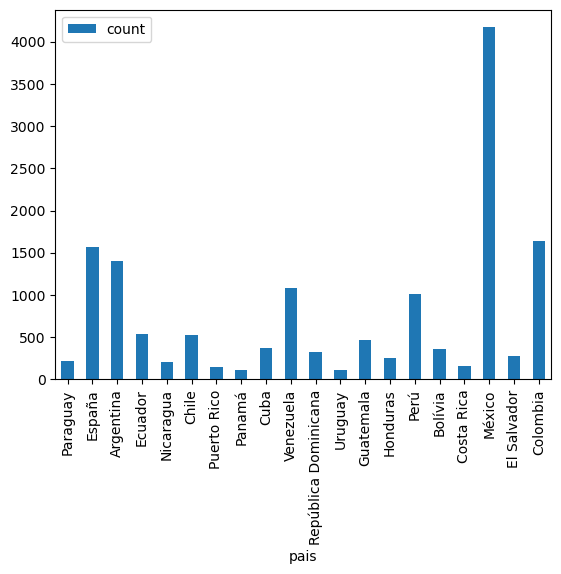

In [10]:
hist_usuarios_pais.set_index('pais').plot(kind='bar')

Podemos ver claramente que el país que más participantes ha tenido ha sido México, y el que menos, parece ser Uruguay. Como no queda muy claro, vamos a ordenar los valores de este histograma usando el método *sort_values*

<Axes: xlabel='pais'>

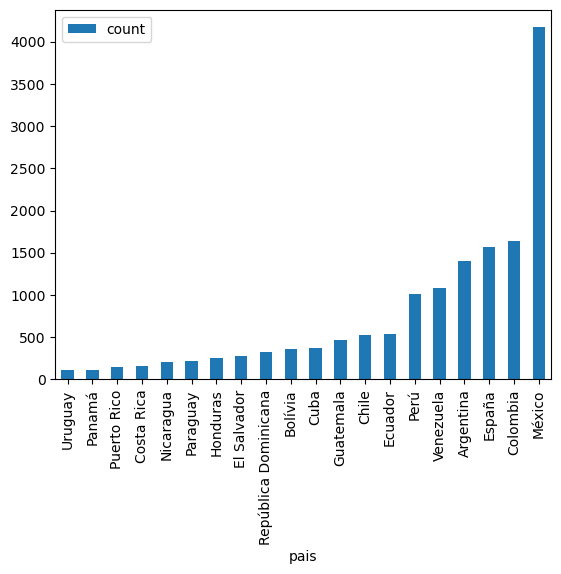

In [11]:
hist_usuarios_pais.set_index('pais').sort_values('count').plot(kind='bar')

Ahora sí podemos ver claramente que Uruguay es el país que menos participantes ha tenido, aunque seguido bien de cerca por Panamá o Puerto Rico, entre otros.

## Edad

En segundo lugar, vamos a estudiar la distribución de edades de los participantes. Para ello, vamos a construir un histograma muy similar al anterior pero, en este caso, en lugar de agrupar por país, vamos a agrupar por edad

In [12]:
hist_usuarios_edad = df_user.groupby('edad').count().toPandas()
hist_usuarios_edad.head()

,edad,count
0,31,433
1,85,4
2,65,81
3,53,261
4,78,14


Para mostrar los datos de este histograma usaremos otro tipo de gráfico, llamado "scatter"

<Axes: xlabel='edad', ylabel='count'>

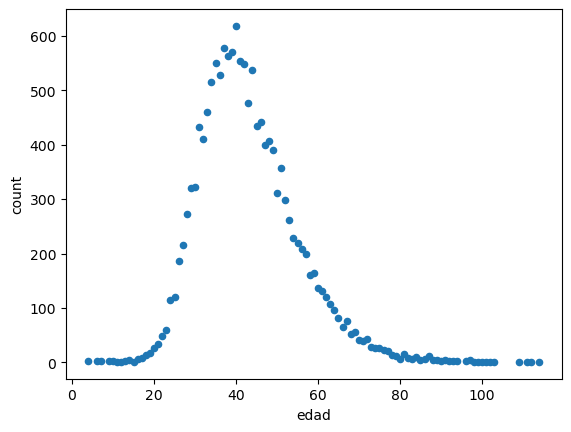

In [13]:
hist_usuarios_edad.plot('edad', 'count', kind='scatter')

En este gráfico podemos ver como hay participantes menores de 10 años y mayores de 100. Más adelante nos va a interesar filtrar los votos de estos usuarios, pues pueden ser poco fiables. Vamos a ver cuantos usuarios hay que tengan menos de 10 años

In [14]:
df_user.filter('edad < 10').count()

8

Ahora queremos saber cuántos usuarios mayores de 100 años han participado

In [15]:
df_user.filter('edad > 100').count()

7

Finalmente, vamos a generar el conjunto de datos limpio filtrando sólo los usuarios que tengan edades comprendidas entre los 10 y los 100 años, ambos incluidos. Generareos este conjunto de datos limpio y contamos cuantos usuarios nos han quedado.

In [16]:
df_user_limpio = df_user.filter('edad >= 10 AND edad <= 100')
df_user_limpio.count()

14904

## Estudio y limpieza de los datos de votos

Una vez analizados los datos de los usuarios, vamos a hacer lo mismo con los votos

In [17]:
df_vote.show(5)

+------------------+----------+-----+------------------+
|        id_galaxia|id_usuario|forma|            tiempo|
+------------------+----------+-----+------------------+
|587739829276311756|     10404|    1| 6.614253100388135|
|587744728760910031|     10404|    1| 35.48928686770822|
|587738195050823924|     10404|    0|2.5945047278529874|
|587735349639184468|     10404|    1|3.2181662463830123|
|588017726552015023|     10404|    1| 7.687655899222958|
+------------------+----------+-----+------------------+
only showing top 5 rows



Y podemos contar cuantos votos hemos recodigo en total usando la método *count()*.

In [18]:
df_vote.count()

379149

## Tiempo de respuesta

Ahora vamos a estudiar la distribución del tiempo de respuesta, para ver cómo de rápido han sido los participantes a la hora de clasificar las galaxias según su forma.

Como puedes observar en el resultado mostrado en la celda anterior, en este caso tenemos una complejidad adicional que es el hecho de que el tiempo de respuesta no es un valor con el cual podamos agrupar directamente, ya que no es un valor categórico y cada voto tiene un tiempo de respuesta distinto.

Para poder agrupar los distintos votos, deberemos crear categorías artificiales, por ejemplo agrupando los tiempos de respuesta en bloques de un segundo. Para llevar a cabo esta agrupación podemos usar la función *floor* en la que, dado un tiempo de respuesta, nos va a devolver la parte entera despreciando la parte decimal. De esta manera, varios votos que hayan tardado 3.425, 3.019 o 3.978 segundos van a quedar agrupados en la misma categoria, los que han tardado de 3 a 4 segundos.

Vamos a generar esta columna extra con el método *withColumn* aplicando esta función *floor*

In [20]:
df_vote.withColumn('segundos', functions.floor('tiempo')).show(10)

+------------------+----------+-----+------------------+--------+
|        id_galaxia|id_usuario|forma|            tiempo|segundos|
+------------------+----------+-----+------------------+--------+
|587739829276311756|     10404|    1| 6.614253100388135|       6|
|587744728760910031|     10404|    1| 35.48928686770822|      35|
|587738195050823924|     10404|    0|2.5945047278529874|       2|
|587735349639184468|     10404|    1|3.2181662463830123|       3|
|588017726552015023|     10404|    1| 7.687655899222958|       7|
|588010358014017710|     10404|    0|  9.79908988078975|       9|
|587737826752594182|     10404|    1| 5.225004023821759|       5|
|587739304222130394|     10404|    0| 5.303747019448238|       5|
|587739828736032881|     10404|    1|  5.34163174692188|       5|
|588017979433353325|     10404|    1|21.725705251771892|      21|
+------------------+----------+-----+------------------+--------+
only showing top 10 rows



Ahora ya podemos agrupar por esta columna nueva y generar el histograma.

In [21]:
hist_votos_tiempo = df_vote.withColumn('segundos', functions.floor('tiempo')).groupby('segundos').count().toPandas()
hist_votos_tiempo.head()

,segundos,count
0,26,2407
1,29,1753
2,65,101
3,191,1
4,19,5113


Visualizaremos ahora un histograma usando el gráfico de tipo "scatter"

<Axes: xlabel='segundos', ylabel='count'>

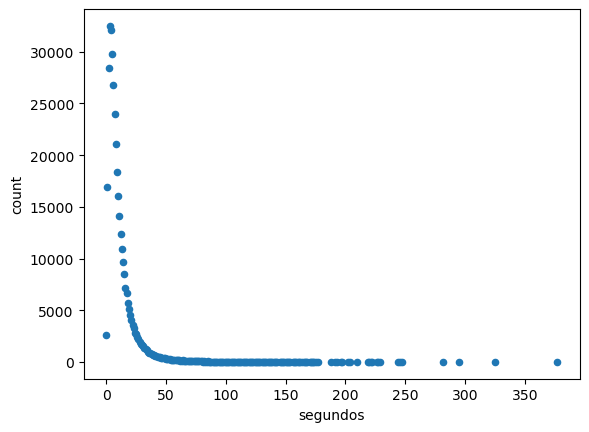

In [22]:
hist_votos_tiempo.plot('segundos', 'count', kind = 'scatter')

Lo primero que podemos ver en este gráfico es que parece ser que hay clasificaciones donde el usuario se ha tomado su tiempo para decidirse. Hay bastantes votos en los que el usuario ha necesitado más de 60 segundos para decidirse, incluso algunos han tardado más de 300 segundos (5 minutos). Es muy probable que no nos interese tener en cuenta estos votos, ya que la información que contienen podría ser problemática.

Calcularemos el número de votos que han tomado 60 segundos o más en generarse

In [23]:
df_vote.filter('tiempo >= 60').count()

2866

Por otro lado, en la visualización anterior perdemos el detalle de lo que sucede para tiempos reducidos. Hay un parámetro *xlim* que se le puede pasar al método *plot* para especificar el rango que queremos que nos muestre en el eje X

<Axes: xlabel='segundos', ylabel='count'>

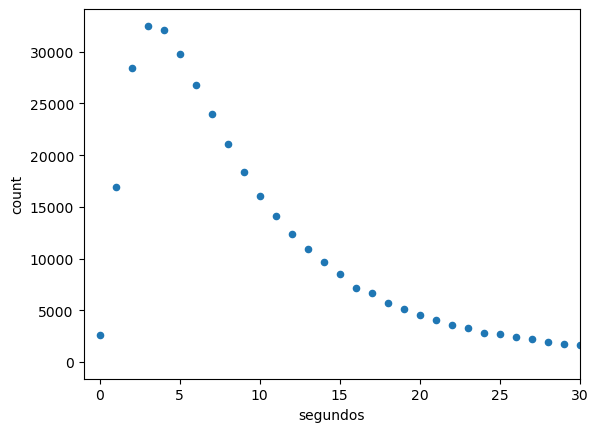

In [24]:
hist_votos_tiempo.plot('segundos', 'count', kind = 'scatter', xlim=[-1,30])

Podemos observar como hay algunas clasificaciones que se han realizado en menos de un segundo, ya que aparecen agrupadas en la coordenada 0. Calculamos el número de votos que se han realizado en menos de un segundo

In [25]:
df_vote.filter('tiempo < 1').count()

2639

Observamos que hay 2639.

Estos votos también podría interesarnos no tenerlos en cuenta, ya que es bastante probable que el usuario no le haya prestado suficiente atención.

Vamos a generar un conjunto de datos limpio que sólo contenga los votos en los que el tiempo de respuesta sea mayor de un segundo y menor de sesenta

In [26]:
df_vote_limpio = df_vote.filter('tiempo > 1 AND tiempo < 60')
df_vote_limpio.show(5)

+------------------+----------+-----+------------------+
|        id_galaxia|id_usuario|forma|            tiempo|
+------------------+----------+-----+------------------+
|587739829276311756|     10404|    1| 6.614253100388135|
|587744728760910031|     10404|    1| 35.48928686770822|
|587738195050823924|     10404|    0|2.5945047278529874|
|587735349639184468|     10404|    1|3.2181662463830123|
|588017726552015023|     10404|    1| 7.687655899222958|
+------------------+----------+-----+------------------+
only showing top 5 rows



Y, por último, usamos el método *count* en este conjunto de datos limpio para calcular cuantos votos nos han quedado después de sanear los datos.

In [27]:
df_vote_limpio.count()

373644

## Combinación de los datos limpios

Ahora que tenemos los dos conjuntos de datos limpios, vamos a combinarlos para estudiarlos en su conjunto. Para ello usaremos el método *join* para combinar ambos por la columna que tienen en común, que es el identificador del usuario.

In [28]:
df_combinado = df_vote_limpio.join(df_user_limpio, 'id_usuario')
df_combinado.show(10)

+----------+------------------+-----+------------------+----+---------+
|id_usuario|        id_galaxia|forma|            tiempo|edad|     pais|
+----------+------------------+-----+------------------+----+---------+
|     10404|587739829276311756|    1| 6.614253100388135|  41|Argentina|
|     10404|587744728760910031|    1| 35.48928686770822|  41|Argentina|
|     10404|587738195050823924|    0|2.5945047278529874|  41|Argentina|
|     10404|587735349639184468|    1|3.2181662463830123|  41|Argentina|
|     10404|588017726552015023|    1| 7.687655899222958|  41|Argentina|
|     10404|588010358014017710|    0|  9.79908988078975|  41|Argentina|
|     10404|587737826752594182|    1| 5.225004023821759|  41|Argentina|
|     10404|587739304222130394|    0| 5.303747019448238|  41|Argentina|
|     10404|587739828736032881|    1|  5.34163174692188|  41|Argentina|
|     10404|588017979433353325|    1|21.725705251771892|  41|Argentina|
+----------+------------------+-----+------------------+----+---

Al combinar estos dos conjuntos de datos vamos a generar un conjunto de datos aún más limpio, ya que en la combinación se van a descartar todos los votos de aquellos usuarios que hemos filtrado por estar fuera del rango de edad.

Calculamos el número de registros del conjunto de datos combinados con el método *count*.

In [30]:
df_combinado.count()

373451

Obtenemos 373451, lo que nos indica que en la combinación de los dos conjuntos de datos, se han descartado $373644 - 373451 = 193$ votos adicionales.

### Votos según el país

Ahora que tenemos los datos combinados, podemos sacar información adicional sobre estos datos. Por ejemplo, podemos calcular el histograma de número de votos por país

In [32]:
hist_votos_pais = df_combinado.groupby('pais').count().toPandas()
hist_votos_pais.head()

,pais,count
0,Paraguay,5511
1,España,39367
2,Argentina,35385
3,Ecuador,13360
4,Nicaragua,5242


<Axes: xlabel='pais'>

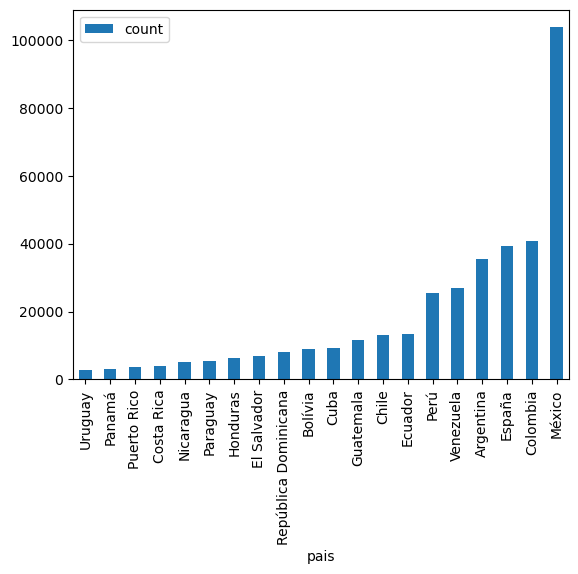

In [34]:
hist_votos_pais.set_index('pais').sort_values('count').plot(kind='bar')

Como era de esperar México sigue liderando en el recuento de votos al tener también el mayor número de usuarios participantes.

El problema con esta visualización es que no podemos determinar si los usuarios de México o los de cualquier otro país han sido más productivos que el resto. Es decir, si los usuarios de algún país han sido generado, de media, más votos de los de otros países. Para saber esto, podemos calcular el número medio de votos por usuario de cada país, dividiendo los datos de los dos histogramas (el de número de votos por país y el de número de usuarios por país).

In [35]:
hist_media_voto_pais = hist_votos_pais.set_index('pais') / hist_usuarios_pais.set_index('pais')
hist_media_voto_pais.head()

,count
pais,
Argentina,25.220955
Bolívia,25.259777
Chile,24.937736
Colombia,24.921760
Costa Rica,24.941935


Vamos a visualizar esta información ahora con un gráfico de barras.

<Axes: xlabel='pais'>

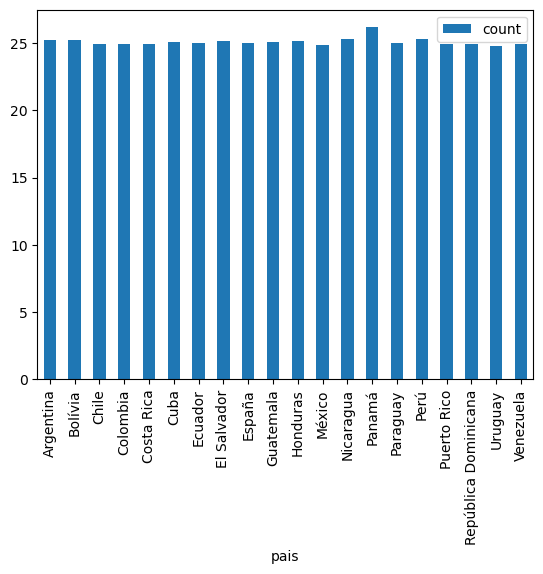

In [36]:
hist_media_voto_pais.plot(kind='bar')

A la vista de la información presentada, no parece haber diferencias significativas en la participación de los usuarios de cada país. De media, cada participante ha clasificado la forma de unas 25 galaxias.

## Votos según la edad

Sucederá lo mismo si estudiamos el número de votos medio segun la franja de edad?

In [38]:
hist_votos_edad = df_combinado.groupby('edad').count().toPandas()
hist_votos_edad.head()

,edad,count
0,31,9573
1,85,125
2,65,2264
3,53,7250
4,78,402


<Axes: xlabel='edad', ylabel='count'>

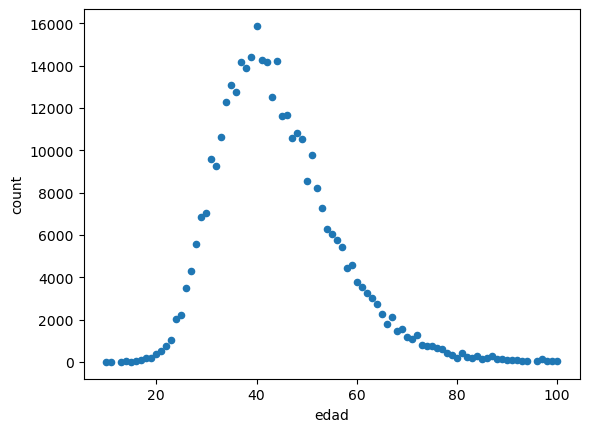

In [39]:
hist_votos_edad.plot('edad', 'count', kind='scatter')

A primera vista vemos una distribución del número de votos según la edad muy similar a la distribución de usuarios según la edad. Esto era esperable ya que las franjas con más usuarios también serán las que deberían haber generado más clasificaciones. Para poder salir de dudas, es necesario hacer como en el caso anterior y dividir la información de los dos histogramas para calcular el número medio de votos segun la edad.

In [40]:
hist_media_voto_edad = hist_votos_edad.set_index('edad') / hist_usuarios_edad.set_index('edad')
hist_media_voto_edad.head(10)

,count
edad,
4,NaN
6,NaN
7,NaN
9,NaN
10,1.00
11,1.00
12,NaN
13,0.50
14,5.25


Los valores 'NaN' en la tabla anterior, corresponden a datos de usuarios o votos que han sido filtrados (por edad o tiempo).

<Axes: xlabel='edad', ylabel='count'>

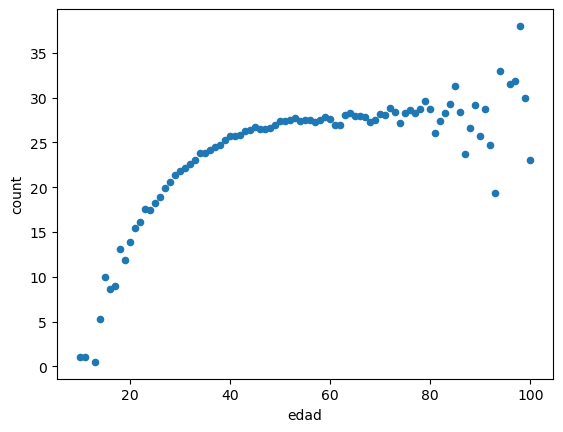

In [41]:
hist_media_voto_edad.reset_index().plot('edad', 'count', kind='scatter')

La gráfica anterior presenta un comportamiento particular que explicare más adelante.


#·· Generar la clasificación promedio

Una vez hemos limpiado y estudiado los datos y estamos conformes con su validez, es el momento de generar la clasificación ideal de cada una de las galaxias. Para ello, vamos a promediar el voto de todos los usuarios sobre cada una de las galaxias. La forma esta codificada a numero: ``0 en caso de votar elíptica``, y ``1 en caso de votar espiral``. Si la mayoría de los usuarios han votado una imagen de una galaxia como elíptica, la media de sus votos debería ser cercana a 0. En caso contrario, si la mayoría de los votos han marcado una galaxia como espiral, la media de la columna forma debería ser cercana a 1.

Antes de continuar, recordemos el aspecto del conjunto de datos combinado con el método show.

In [43]:
df_combinado.show(5)

+----------+------------------+-----+------------------+----+---------+
|id_usuario|        id_galaxia|forma|            tiempo|edad|     pais|
+----------+------------------+-----+------------------+----+---------+
|     10404|587739829276311756|    1| 6.614253100388135|  41|Argentina|
|     10404|587744728760910031|    1| 35.48928686770822|  41|Argentina|
|     10404|587738195050823924|    0|2.5945047278529874|  41|Argentina|
|     10404|587735349639184468|    1|3.2181662463830123|  41|Argentina|
|     10404|588017726552015023|    1| 7.687655899222958|  41|Argentina|
+----------+------------------+-----+------------------+----+---------+
only showing top 5 rows



Para generar la clasificación promedio, debemos agrupar por la columna que identifica únicamente a cada galaxia y calcular la media del campo forma

In [58]:
df_clasificado = df_combinado.groupby('id_galaxia').agg(functions.avg('forma').alias('forma'))
df_clasificado.show(5)

+------------------+------------------+
|        id_galaxia|             forma|
+------------------+------------------+
|587739506615386262|0.7368421052631579|
|587728879267872938|               0.5|
|587733427088588918|0.9642857142857143|
|587730815749849294|0.5384615384615384|
|588017725474275701|0.8732394366197183|
+------------------+------------------+
only showing top 5 rows



In [70]:
a= df_clasificado.toPandas()
print(a)

              id_galaxia     forma
0     587739506615386262  0.736842
1     587728879267872938  0.500000
2     587733427088588918  0.964286
3     587730815749849294  0.538462
4     588017725474275701  0.873239
...                  ...       ...
9995  588016525560578172  0.428571
9996  587732592251437082  0.483871
9997  587741568198770747  0.947368
9998  588017979986542925  0.266667
9999  587725492670693628  0.157895

[10000 rows x 2 columns]


Podemos ver como para cada galaxia hemos obtenido su forma esperada segun la media de los votos. El último paso que nos queda es guardar esta información en otra tabla, que va a ser usada para entrenar un clasificador automatizado.

**Nota: para poder guardarlo sin usar hadoop, pasare el dataframe de spark a pandas**

In [71]:
df = df_clasificado.toPandas()
df.to_csv("clasificado.csv", index=False)

In [ ]:
# Detenemos la instancia de Spark
spark.stop()